In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-23 12:23:31.495249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.044344,-1.318725,-2.020148,-0.554069,0.011276,-0.829771,-2.862801,-0.937871,-0.029335,-0.079737,...,-0.171958,-0.408107,-0.295392,-1.181492,-0.158178,0.011724,0.134771,-0.202173,-0.251086,-0.257935
1,-1.010345,-1.084419,-1.768553,-0.561297,-0.323891,-0.822472,-2.610682,-0.896614,-0.009458,-0.095426,...,-0.729691,-0.589988,-0.358002,-0.952563,0.049743,-0.022304,-0.315429,-0.437890,-0.758958,-0.282723
2,-0.264528,-1.164834,-1.780863,-0.491005,0.132880,-0.774631,-1.938029,-1.241575,-0.086820,-0.015274,...,-1.056200,-0.852987,-0.413210,-1.052634,0.117768,0.219654,-0.375627,-0.064497,-0.934184,-0.203839


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.210754,-1.321157,-2.145946,-0.151770,-0.155471,-0.775024,-2.385527,-1.495634,-0.418926,-0.075728,...,-0.499942,-0.513059,-0.424530,-1.244153,0.015781,0.078829,-0.196167,-0.524460,-1.037056,-0.314540
1,-0.126822,-1.382013,-2.173479,-0.208718,0.161889,-0.884878,-2.025593,-1.293933,-0.018025,0.045924,...,-0.736620,-0.432284,-0.507320,-1.781393,0.026585,0.059345,0.072144,0.047436,-0.541746,-0.602892
2,-0.387433,-1.079072,-2.346600,-0.331100,-0.102896,-0.669190,-2.169554,-0.808801,0.114080,-0.072095,...,-0.607937,-0.741635,-0.450178,-1.243914,-0.092732,0.055465,-0.369650,-0.256188,-0.590345,-0.260363


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=56,
    batch_size=112,
    encoder_batch_norm=True,
    epochs=305, 
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-23 12:23:37.257241: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/305
7/7 [==============================] - 2s 145ms/step - loss: 1998.5026 - recon: 1971.0106 - kl: 27.4922 - val_loss: 17160.5020 - val_recon: 14152.9814 - val_kl: 3007.5193
Epoch 2/305
7/7 [==============================] - 1s 118ms/step - loss: 1073.0051 - recon: 1045.9756 - kl: 27.0294 - val_loss: 32602.5117 - val_recon: 29050.9805 - val_kl: 3551.5305
Epoch 3/305
7/7 [==============================] - 1s 134ms/step - loss: 741.0596 - recon: 713.3537 - kl: 27.7060 - val_loss: 24955.3418 - val_recon: 21849.5527 - val_kl: 3105.7900
Epoch 4/305
7/7 [==============================] - 1s 157ms/step - loss: 624.4583 - recon: 596.6951 - kl: 27.7632 - val_loss: 20075.1445 - val_recon: 18168.6406 - val_kl: 1906.5050
Epoch 5/305
7/7 [==============================] - 1s 137ms/step - loss: 556.1077 - recon: 528.4814 - kl: 27.6262 - val_loss: 8724.5117 - val_recon: 7576.6680 - val_kl: 1147.8436
Epoch 6/305
7/7 [==============================] - 1s 129ms/step - loss: 465.4354 - recon: 43

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

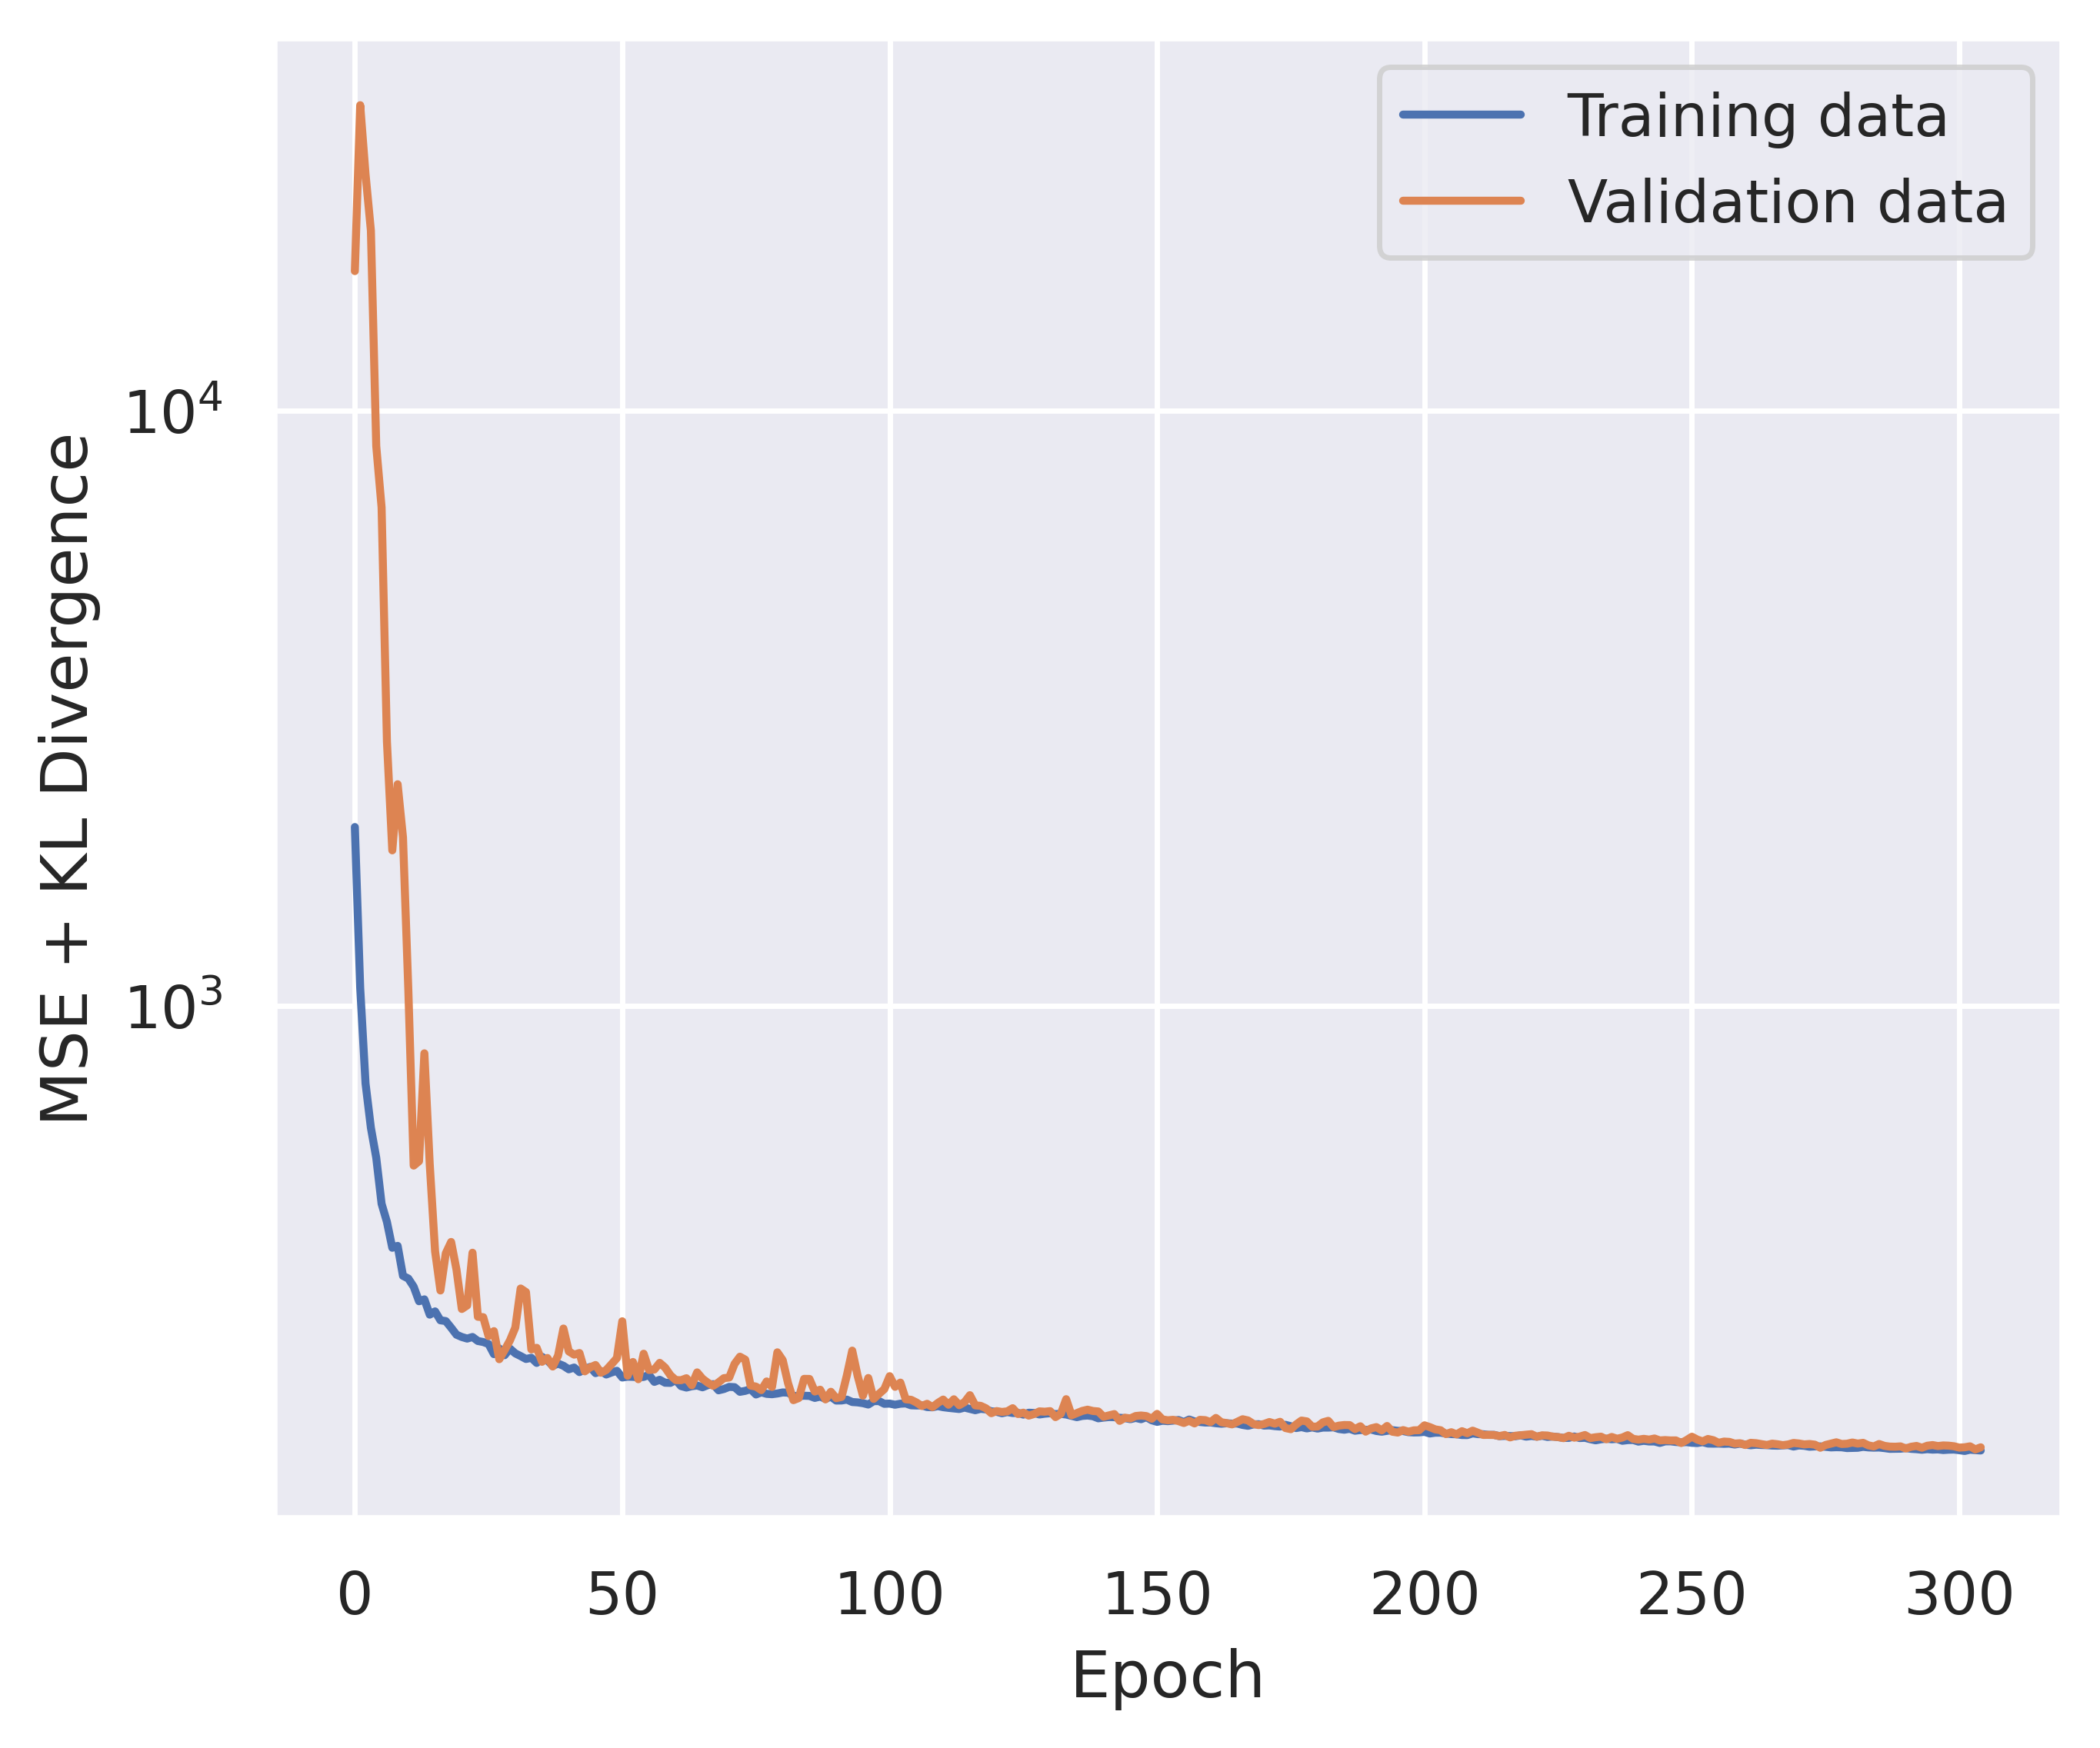

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001549,Adult,Male,train
1,ACH-001992,Adult,Male,train
2,ACH-000035,Adult,Male,train
3,ACH-000911,Adult,Male,train
4,ACH-000259,Pediatric,Female,train
...,...,...,...,...
907,ACH-000858,Adult,Male,test
908,ACH-000514,Adult,Male,test
909,ACH-000258,Adult,Female,test
910,ACH-002446,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 1s 35ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,46,47,48,49,50,51,52,53,54,55
0,ACH-001549,0.641828,2.255752,0.576668,-0.298168,0.784063,1.417404,1.015673,1.217430,0.696243,...,-0.420182,0.285047,0.122526,-0.465228,-1.232091,2.019001,-0.656772,0.928948,-0.049118,0.971279
1,ACH-001992,1.632426,-0.214917,0.720797,1.184558,-0.456258,-0.020685,0.078458,1.447003,-0.891646,...,1.613086,0.867021,1.855364,1.396982,-0.343896,0.787118,-1.283468,0.792897,-1.442803,1.983561
2,ACH-000035,0.979069,0.280593,-0.386872,1.442345,-0.507138,0.032205,1.316004,-0.628803,-1.305066,...,0.389728,0.009500,2.060703,-0.252914,1.239301,-0.640129,0.721773,-0.396399,0.601583,0.154491
3,ACH-000911,-1.096082,-0.138509,0.793402,0.471544,0.505639,-0.863082,1.078274,0.602074,1.284546,...,0.594805,-1.081738,1.628239,0.108383,0.467460,-0.080298,-0.766951,0.951760,-1.124195,-0.422572
4,ACH-000259,-1.029162,0.433893,1.441033,-0.415763,-0.601139,0.215967,-0.880476,1.124915,-1.591494,...,1.110953,-0.999373,-0.476490,-0.433291,0.761746,2.948964,-0.437494,-0.517973,0.754666,0.462690


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-0.091149,-0.044336,-0.001164,-0.037848,0.047344,0.001991,-0.000425,-0.036371,0.041469,0.022506,...,-0.039370,0.074685,-0.076645,0.066460,-0.015115,0.039723,0.054191,0.011207,0.001318,-0.068258
1,-0.017030,0.048581,0.056772,-0.001898,0.035648,0.021300,0.030531,0.012215,-0.019249,0.032476,...,-0.023777,0.047925,0.058790,-0.016032,-0.083656,0.062707,0.067716,0.005043,-0.073420,-0.039103
2,-0.039453,0.018107,-0.022514,0.052101,0.019628,-0.051332,-0.083455,-0.002061,-0.009793,-0.062815,...,0.002679,0.026534,0.050352,0.000896,-0.018615,-0.055388,-0.034207,0.089190,-0.027525,0.043509
3,-0.046879,-0.030311,-0.053646,0.018475,0.064843,-0.021673,-0.013186,-0.066008,-0.034474,-0.022253,...,-0.016705,0.076802,0.030123,-0.029903,-0.012807,-0.052552,-0.037671,0.065382,-0.034419,0.025500
4,-0.010881,0.082702,-0.081489,0.002027,-0.003736,-0.046454,-0.001526,0.056241,-0.030425,0.002893,...,0.003135,-0.063538,-0.002247,-0.038125,0.001084,-0.060792,-0.016287,-0.027383,0.031234,-0.084249


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,AAAS,-0.091149,-0.044336,-0.001164,-0.037848,0.047344,0.001991,-0.000425,-0.036371,0.041469,...,-0.039370,0.074685,-0.076645,0.066460,-0.015115,0.039723,0.054191,0.011207,0.001318,-0.068258
1,AAMP,-0.017030,0.048581,0.056772,-0.001898,0.035648,0.021300,0.030531,0.012215,-0.019249,...,-0.023777,0.047925,0.058790,-0.016032,-0.083656,0.062707,0.067716,0.005043,-0.073420,-0.039103
2,AARS1,-0.039453,0.018107,-0.022514,0.052101,0.019628,-0.051332,-0.083455,-0.002061,-0.009793,...,0.002679,0.026534,0.050352,0.000896,-0.018615,-0.055388,-0.034207,0.089190,-0.027525,0.043509
3,AARS2,-0.046879,-0.030311,-0.053646,0.018475,0.064843,-0.021673,-0.013186,-0.066008,-0.034474,...,-0.016705,0.076802,0.030123,-0.029903,-0.012807,-0.052552,-0.037671,0.065382,-0.034419,0.025500
4,AASDHPPT,-0.010881,0.082702,-0.081489,0.002027,-0.003736,-0.046454,-0.001526,0.056241,-0.030425,...,0.003135,-0.063538,-0.002247,-0.038125,0.001084,-0.060792,-0.016287,-0.027383,0.031234,-0.084249
